In [7]:
# Load Libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


In [3]:
# Load dataset 
path = ("../../Data/grey_water_management.csv")
df = pd.read_csv(path)

In [4]:
# Select input and output columns
features = ['TDS (mg/l)', 'Turbidity (NTU)', 'pH', 'Depth (m)']
targets = ['Flow Discharge (L/min)', 'Filter Life Span (hours)']
X = df[features]
y = df[targets]

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [6]:
# Train MLPRegressor
model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=2000, random_state=42))
model.fit(X_train, y_train)

# Predict on full input range grid for visualization (sample synthetic configs)
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# Scale input features to generate synthetic grid
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
grid_points = np.linspace(0, 1, 10)
synthetic_scaled = np.array(list(product(*[grid_points]*X.shape[1])))
synthetic_original = scaler.inverse_transform(synthetic_scaled)

# Predict outcomes using trained model
preds = model.predict(synthetic_original)

# Combine and sort
df_synthetic = pd.DataFrame(synthetic_original, columns=features)
df_synthetic['Flowrate'] = preds[:, 0]
df_synthetic['Lifespan'] = preds[:, 1]
df_sorted = df_synthetic.sort_values(by=['Flowrate', 'Lifespan'], ascending=[False, False]).reset_index(drop=True)

# Show top 20 predicted sweet spots
df_sorted.head(20)

c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


,TDS (mg/l),Turbidity (NTU),pH,Depth (m),Flowrate,Lifespan
0,55.556667,9.999,8.5,4.999000,62.206491,4048.097116
1,499.962000,0.000,8.5,4.999000,62.149653,4338.285333
2,55.556667,8.888,8.5,4.999000,62.004702,4084.127868
3,499.962000,1.111,8.5,4.999000,61.906756,4268.889273
4,55.556667,7.777,8.5,4.999000,61.876017,4136.809470
5,499.962000,0.000,8.5,4.499222,61.851335,4371.966903
6,55.556667,6.666,8.5,4.999000,61.716389,4189.812455
7,499.962000,2.222,8.5,4.999000,61.663860,4199.353806
8,55.556667,9.999,8.5,4.499222,61.617422,4081.886712
9,499.962000,1.111,8.5,4.499222,61.608439,4304.838796


c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


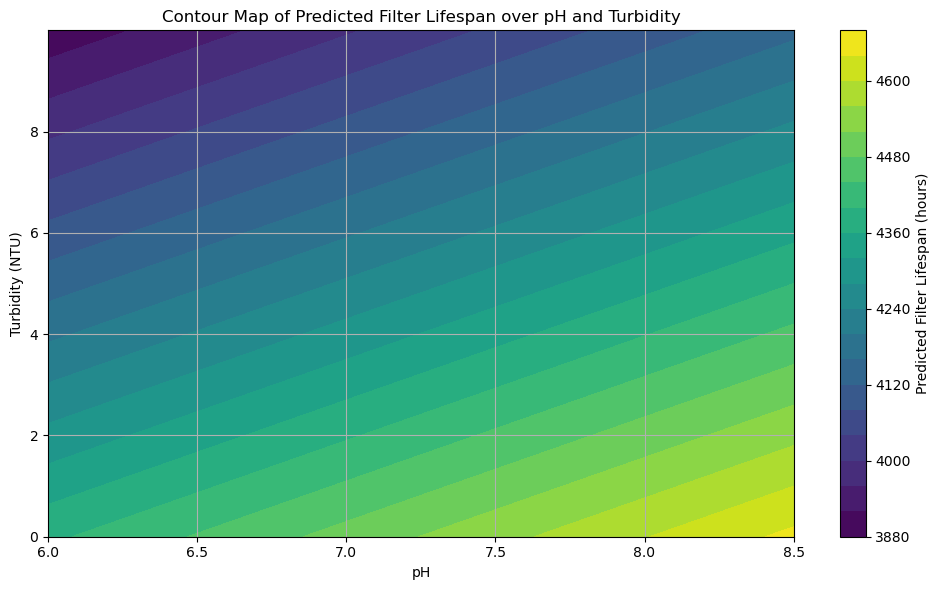

In [8]:
# Use MLP model trained earlier and features from full dataset
# Fix TDS and Depth at their median values to visualize the effect of pH and Turbidity
tds_median = df['TDS (mg/l)'].median()
depth_median = df['Depth (m)'].median()

# Create a grid of pH and turbidity values
pH_vals = np.linspace(df['pH'].min(), df['pH'].max(), 50)
turbidity_vals = np.linspace(df['Turbidity (NTU)'].min(), df['Turbidity (NTU)'].max(), 50)
pH_grid, turbidity_grid = np.meshgrid(pH_vals, turbidity_vals)

# Flatten and create input array for predictions
X_grid = np.column_stack([
    np.full(pH_grid.size, tds_median),
    turbidity_grid.ravel(),
    pH_grid.ravel(),
    np.full(pH_grid.size, depth_median)
])

# Predict lifespan using MLP model
lifespan_pred = model.predict(X_grid)[:, 1]  # only take lifespan prediction

# Reshape to match the grid
lifespan_grid = lifespan_pred.reshape(pH_grid.shape)

# Plot contour map
plt.figure(figsize=(10, 6))
contour = plt.contourf(pH_grid, turbidity_grid, lifespan_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label="Predicted Filter Lifespan (hours)")
plt.xlabel("pH")
plt.ylabel("Turbidity (NTU)")
plt.title("Contour Map of Predicted Filter Lifespan over pH and Turbidity")
plt.grid(True)
plt.tight_layout()
plt.show()

Above is the contour map showing predicted filter lifespan across varying pH and turbidity values, while keeping:

- TDS fixed at its median

- Depth fixed at its median

How to Interpret This:

- Color indicates predicted filter life span (in hours)

- The brightest zones represent optimal operating ranges

    - Usually higher pH and lower turbidity lead to longer filter lifespan

- The dark regions show where filters are expected to degrade faster

c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\jpodichetty\Anaconda3\envs\iRI_25_AS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


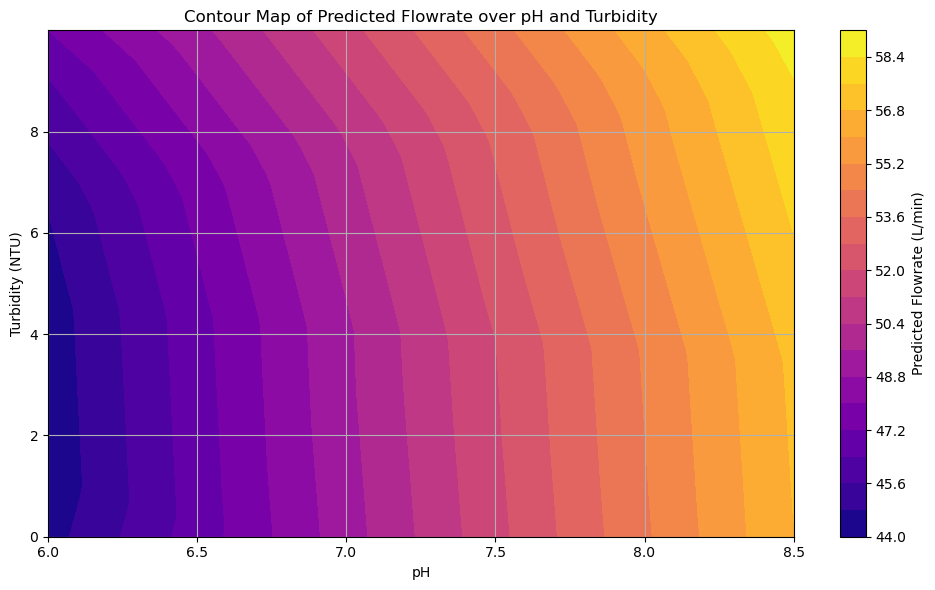

In [9]:
# Predict flowrate across the same pH and turbidity grid
flowrate_pred = model.predict(X_grid)[:, 0]  # flowrate is the first output

# Reshape to match the grid
flowrate_grid = flowrate_pred.reshape(pH_grid.shape)

# Plot contour map for flowrate
plt.figure(figsize=(10, 6))
contour = plt.contourf(pH_grid, turbidity_grid, flowrate_grid, levels=20, cmap='plasma')
plt.colorbar(contour, label="Predicted Flowrate (L/min)")
plt.xlabel("pH")
plt.ylabel("Turbidity (NTU)")
plt.title("Contour Map of Predicted Flowrate over pH and Turbidity")
plt.grid(True)
plt.tight_layout()
plt.show()

Above is the contour map for predicted flowrate over the same grid of pH and turbidity, with TDS and depth held constant.
Warmer colors (yellow/orange) = higher flowrate

Flowrate tends to:

Increase slightly with pH

Decrease with rising turbidity (especially at low pH)


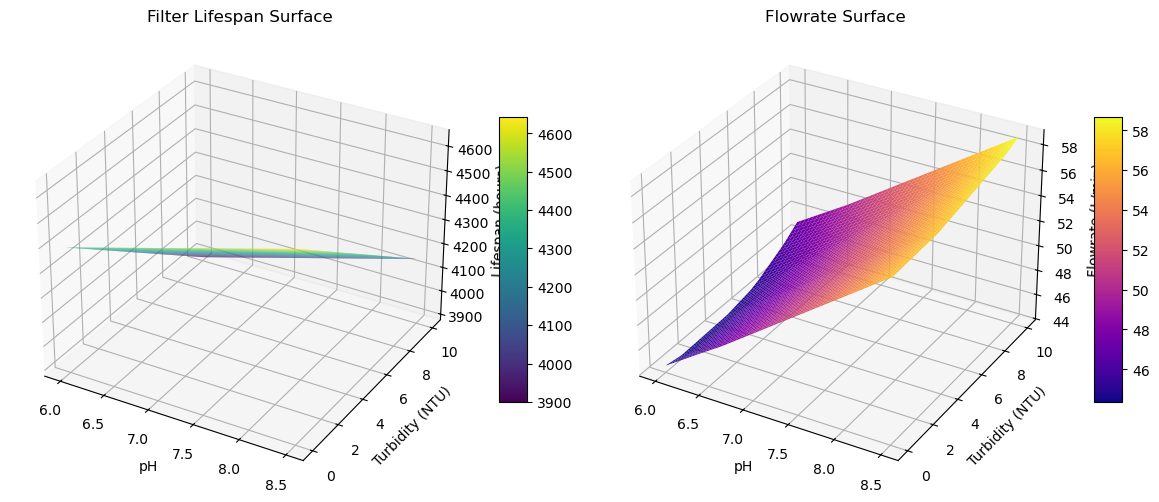

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D surface plot for filter lifespan
fig = plt.figure(figsize=(12, 6))

# Lifespan surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(pH_grid, turbidity_grid, lifespan_grid, cmap='viridis', edgecolor='none')
ax1.set_title("Filter Lifespan Surface")
ax1.set_xlabel("pH")
ax1.set_ylabel("Turbidity (NTU)")
ax1.set_zlabel("Lifespan (hours)")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# Flowrate surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(pH_grid, turbidity_grid, flowrate_grid, cmap='plasma', edgecolor='none')
ax2.set_title("Flowrate Surface")
ax2.set_xlabel("pH")
ax2.set_ylabel("Turbidity (NTU)")
ax2.set_zlabel("Flowrate (L/min)")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

3D surface plots for:

Left: Filter Lifespan
Shows how lifespan varies with pH and turbidity

Highest lifespan is at high pH and low turbidity

Right: Flowrate
Shows flowrate behavior across the same grid

Flowrate also improves with high pH, but drops with turbidity

Summary:
These surfaces let you identify optimal pH/turbidity zones for simultaneous performance and durability.

Future work: build a recommendation engine or control logic like:

“Maintain pH above 7.5 and turbidity below 2 NTU to stay in the green zone.”